# Joint friction estimation for a 6 DOF robotic manipulator

## Imports

In [4]:
import os
from nnodely import *
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from nnodely.support.earlystopping import select_best_model
from nnodely.support import earlystopping
from nnodely.support.jsonutils import plot_graphviz_structure
import torch

## Global variables


In [6]:
ROOT           = os.getcwd()
WS             = os.path.join(ROOT, 'model')
DATASET_NAME   = "dataset"
TRAIN_DATASET_FOLDER = os.path.join(ROOT, DATASET_NAME, "train")
VALIDATION_DATASET_FOLDER = os.path.join(ROOT, DATASET_NAME, "validation")
TEST_DATASET_FOLDER = os.path.join(ROOT, DATASET_NAME, "test")
PLOT_VIZ       = False
SEED           = 345

## Setup


In [7]:
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float32)

if not os.path.exists(WS):
    os.makedirs(WS)

## Training the model

Create the nnodely instance


In [8]:
z1_model = nnodely(visualizer=TextVisualizer(), seed=SEED, workspace=WS)

Define the functions that will be used from the nnodely model

In [9]:
def friction(dq, K_v, K_c, K_s):
    import torch
    first = K_v * dq
    second = K_c * torch.tanh(dq * 50)
    stribeck = torch.tanh(dq * 50) * (K_s - K_c) * torch.exp(- (torch.abs(dq/K_s))**2)
    return first + second + stribeck

def ddq(q, dq, tau):
    import torch
    from adam.pytorch.computation_batch import KinDynComputationsBatch
    torch.set_default_device('cpu')
    torch.set_default_dtype(torch.float32)
    robot = '/home/dema/friction_estimation/z1_description.urdf'  

    joints_name_list = ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']
    kinDyn = KinDynComputationsBatch(robot, joints_name_list, device='cpu', dtype=torch.float32)
    q = q.squeeze(1)
    dq = dq.squeeze(1)
    tau = tau.squeeze(1)
    tau_full = torch.concat((torch.zeros(tau.shape[0], 6), tau), dim=1)
    
    B = q.shape[0]

    H_b = torch.eye(4).expand(B, 4, 4)   
    v_b = torch.zeros(B, 6)       

    M = kinDyn.mass_matrix(H_b, q)
    h = kinDyn.bias_force(H_b, q, v_b, dq)
    t = tau_full - h

    ddq_full = (torch.linalg.inv(M[:,6:,6:]) @ t[:,6:].unsqueeze(-1)).squeeze(-1)
    ddq_full = ddq_full.unsqueeze(1)

    return ddq_full

Define the inputs and the relations

In [10]:
q1          = Input('q1')
q2          = Input('q2')
q3          = Input('q3')
q4          = Input('q4')
q5          = Input('q5')
q6          = Input('q6')
dq1         = Input('dq1')
dq2         = Input('dq2')
dq3         = Input('dq3')
dq4         = Input('dq4')
dq5         = Input('dq5')
dq6         = Input('dq6')
tau1        = Input('tau1')
tau2        = Input('tau2')
tau3        = Input('tau3')
tau4        = Input('tau4')
tau5        = Input('tau5')
tau6        = Input('tau6')
ddq1_target = Input('ddq1')
ddq2_target = Input('ddq2')
ddq3_target = Input('ddq3')
ddq4_target = Input('ddq4')
ddq5_target = Input('ddq5')
ddq6_target = Input('ddq6')


coul_visc_fric1 = ParamFun(friction)
coul_visc_fric2 = ParamFun(friction)
coul_visc_fric3 = ParamFun(friction)
coul_visc_fric4 = ParamFun(friction)
coul_visc_fric5 = ParamFun(friction)
coul_visc_fric6 = ParamFun(friction)

fuzzy_q1 = Fuzzify(centers=[0.0, 1.57])(q1.last())
fuzzy_q2 = Fuzzify(centers=[0.0, 1.57])(q2.last())
fuzzy_q3 = Fuzzify(centers=[0.0, 1.57])(q3.last())
fuzzy_q4 = Fuzzify(centers=[0.0, 1.57])(q4.last())
fuzzy_q5 = Fuzzify(centers=[0.0, 1.57])(q5.last())
fuzzy_q6 = Fuzzify(centers=[0.0, 1.57])(q6.last())

local_1 = LocalModel(input_function=coul_visc_fric1)(dq1.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))
local_2 = LocalModel(input_function=coul_visc_fric2)(dq2.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))
local_3 = LocalModel(input_function=coul_visc_fric3)(dq3.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))
local_4 = LocalModel(input_function=coul_visc_fric4)(dq4.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))
local_5 = LocalModel(input_function=coul_visc_fric5)(dq5.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))
local_6 = LocalModel(input_function=coul_visc_fric6)(dq6.last(), (fuzzy_q1, fuzzy_q2, fuzzy_q3, fuzzy_q4, fuzzy_q5, fuzzy_q6))

tau1_in = tau1.last() - local_1
tau2_in = tau2.last() - local_2
tau3_in = tau3.last() - local_3
tau4_in = tau4.last() - local_4
tau5_in = tau5.last() - local_5
tau6_in = tau6.last() - local_6

tau_final = Concatenate(tau1_in, tau2_in)
tau_final = Concatenate(tau_final,   tau3_in)
tau_final = Concatenate(tau_final,   tau4_in)
tau_final = Concatenate(tau_final,   tau5_in)
tau_final = Concatenate(tau_final,   tau6_in)

q = Concatenate(q1.last(), q2.last())
q = Concatenate(q,         q3.last())
q = Concatenate(q,         q4.last())
q = Concatenate(q,         q5.last())
q = Concatenate(q,         q6.last())

dq = Concatenate(dq1.last(), dq2.last())
dq = Concatenate(dq,         dq3.last())   
dq = Concatenate(dq,         dq4.last())
dq = Concatenate(dq,         dq5.last())
dq = Concatenate(dq,         dq6.last())

ddq_target = Concatenate(ddq1_target.last(), ddq2_target.last())
ddq_target = Concatenate(ddq_target,         ddq3_target.last())
ddq_target = Concatenate(ddq_target,         ddq4_target.last())
ddq_target = Concatenate(ddq_target,         ddq5_target.last())
ddq_target = Concatenate(ddq_target,         ddq6_target.last())

# Define the parameterized function for ddq
ddq_out = ParamFun(ddq)(q, dq, tau_final)

# Define the output of the model
output = Output('ddq_out', ddq_out)

Build the model

In [11]:
z1_model.addModel('acc', [output])
z1_model.addMinimize('acc_error', output, ddq_target, loss_function='mse')
z1_model.neuralizeModel(0.002)

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FFuzzify31': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify32': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify33': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify34': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify35': 

Load the dataset

In [12]:
data_struct = ['time', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6',
               'dq1', 'dq2', 'dq3', 'dq4', 'dq5', 'dq6',
               'ddq1', 'ddq2', 'ddq3', 'ddq4', 'ddq5', 'ddq6',
               'tau1', 'tau2', 'tau3', 'tau4', 'tau5', 'tau6']

train_dataset_name = "train_data"
validation_dataset_name = "validation_data"
test_dataset_name  = "test_data"

z1_model.loadData(name=train_dataset_name, source=TRAIN_DATASET_FOLDER, format=data_struct, skiplines=1)
z1_model.loadData(name=validation_dataset_name, source=VALIDATION_DATASET_FOLDER, format=data_struct, skiplines=1)
z1_model.loadData(name=test_dataset_name, source=TEST_DATASET_FOLDER, format=data_struct, skiplines=1)

============================ nnodely Model Dataset =============================
Dataset Name:                 train_data
Number of files:              78
Total number of samples:      7800
Shape of ddq6:                (7800, 1, 1)
Shape of ddq5:                (7800, 1, 1)
Shape of ddq4:                (7800, 1, 1)
Shape of ddq3:                (7800, 1, 1)
Shape of ddq2:                (7800, 1, 1)
Shape of ddq1:                (7800, 1, 1)
Shape of q6:                  (7800, 1, 1)
Shape of q5:                  (7800, 1, 1)
Shape of q4:                  (7800, 1, 1)
Shape of q3:                  (7800, 1, 1)
Shape of q2:                  (7800, 1, 1)
Shape of q1:                  (7800, 1, 1)
Shape of dq6:                 (7800, 1, 1)
Shape of tau6:                (7800, 1, 1)
Shape of dq5:                 (7800, 1, 1)
Shape of tau5:                (7800, 1, 1)
Shape of dq4:                 (7800, 1, 1)
Shape of tau4:                (7800, 1, 1)
Shape of dq3:                 (7800,

Train the model and save it in the working directory

In [13]:
params = {
    'num_of_epochs': 200,
    'train_batch_size': 128,
    'val_batch_size': 128,
    'test_batch_size': 128,
    'train_dataset': train_dataset_name,
    'validation_dataset': validation_dataset_name,
    'test_dataset': test_dataset_name,
    'lr': 0.005,
    'shuffle_data': True,
    'select_model': select_best_model,
    'early_stopping': earlystopping.early_stop_patience,
    'early_stopping_params': {
        'patience': 15,
        'error': 'acc_error'
    }
}

z1_model.trainModel(training_params=params) 

z1_model.saveModel("trained_model")

[_setup_recurrent_variables] The value of the prediction_samples=0 but the network has no recurrent variables.
======================== nnodely Model Train Parameters ========================
models:                       ['acc']
num of epochs:                200
update per epochs:            60
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'acc_error', 'patience': 15}
train dataset:                train_data
	- batch size:                128
	- num of samples:            7800
validation dataset:           validation_data
	- batch size:                128
	- num of samples:            2200
minimizers:                   {'acc_error': {'A': 'ParamFun5474',
                                             'B': 'Concatenate5473',
                                             'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.005}
optimizer p

## Test the trained model

Update global variables


In [14]:
DATASET_FOLDER = os.path.join(ROOT, DATASET_NAME, "test")

### No friction

Load the model without the friction compensation

In [15]:
z1_inference = nnodely(visualizer=MPLVisualizer(), workspace=WS, seed=SEED)
z1_inference.loadModel(name="no_friction", model_folder=WS)
z1_inference.neuralizeModel(0.01)

=============================== Load JSON Model ================================
Model loaded from:            /home/dema/notebook/model/no_friction.json
================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun43': {'code': 'def ddq(q, dq, tau):\n'
                                       '    import torch\n'
                                       '    from '
                                       'adam.pytorch.computation_batch import '
                                       'KinDynComputationsBatch\n'
                                       "    torch.set_default_device('cpu')\n"
                                       '    '
                                       'torch.set_default_dtype(torch.float32)\n'
                                       '    robot = '
                                       "'/home/dema/friction_estimation/z1_description.urdf'  \n"
                                       '\n'
                      

Load the dataset

In [16]:
z1_inference.loadData(
    name='test',
    source=DATASET_FOLDER,
    format=data_struct,
    skiplines=1
)

============================ nnodely Model Dataset =============================
Dataset Name:                 test
Number of files:              10
Total number of samples:      1000
Shape of ddq1:                (1000, 1, 1)
Shape of ddq2:                (1000, 1, 1)
Shape of ddq3:                (1000, 1, 1)
Shape of ddq4:                (1000, 1, 1)
Shape of ddq5:                (1000, 1, 1)
Shape of ddq6:                (1000, 1, 1)
Shape of dq1:                 (1000, 1, 1)
Shape of dq2:                 (1000, 1, 1)
Shape of dq3:                 (1000, 1, 1)
Shape of dq4:                 (1000, 1, 1)
Shape of dq5:                 (1000, 1, 1)
Shape of dq6:                 (1000, 1, 1)
Shape of q1:                  (1000, 1, 1)
Shape of q2:                  (1000, 1, 1)
Shape of q3:                  (1000, 1, 1)
Shape of q4:                  (1000, 1, 1)
Shape of q5:                  (1000, 1, 1)
Shape of q6:                  (1000, 1, 1)
Shape of tau1:                (1000, 1, 1)

Start the evaluation

In [17]:

computed_ddq_no_friction = []
real_ddq_no_friction = []

for i in trange(1000):

    samples_test = z1_inference.getSamples('test', index=i)
    start_time = time.time()
    out_nn_test_set = z1_inference(samples_test, sampled=True)
    end_time = time.time()

    nn_output = np.asarray(out_nn_test_set['ddq_out'])

    nn_output = nn_output.reshape(-1, 6)

    computed_ddq_no_friction.append(nn_output)

    ddq_real = np.array([[
        samples_test['ddq1'], samples_test['ddq2'], samples_test['ddq3'],
        samples_test['ddq4'], samples_test['ddq5'], samples_test['ddq6']
    ]])

    real_ddq_no_friction.append(ddq_real)


computed_ddq_no_friction = np.vstack(computed_ddq_no_friction)   
real_ddq_no_friction = np.vstack(real_ddq_no_friction)          

real_ddq_no_friction = real_ddq_no_friction.reshape(computed_ddq_no_friction.shape)

100%|██████████| 1000/1000 [00:16<00:00, 62.01it/s]


### Friction compensation

Load the trained with friction compensation

In [18]:
z1_inference = nnodely(visualizer=MPLVisualizer(), workspace=WS, seed=SEED)
z1_inference.loadModel(name="trained_model", model_folder=WS)
z1_inference.neuralizeModel(0.01)

=============================== Load JSON Model ================================
Model loaded from:            /home/dema/notebook/model/trained_model.json
================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FFuzzify31': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify32': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify33': {'centers': [0.0, 1.57],
                              'dim_out': {'dim': 2},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify34': {'centers': [0.0, 1.57],
                              'dim_ou

Load the data

In [19]:
z1_inference.loadData(
    name='test',
    source=DATASET_FOLDER,
    format=data_struct,
    skiplines=1
)

============================ nnodely Model Dataset =============================
Dataset Name:                 test
Number of files:              10
Total number of samples:      1000
Shape of ddq1:                (1000, 1, 1)
Shape of ddq2:                (1000, 1, 1)
Shape of ddq3:                (1000, 1, 1)
Shape of ddq4:                (1000, 1, 1)
Shape of ddq5:                (1000, 1, 1)
Shape of ddq6:                (1000, 1, 1)
Shape of dq1:                 (1000, 1, 1)
Shape of dq2:                 (1000, 1, 1)
Shape of dq3:                 (1000, 1, 1)
Shape of dq4:                 (1000, 1, 1)
Shape of dq5:                 (1000, 1, 1)
Shape of dq6:                 (1000, 1, 1)
Shape of q1:                  (1000, 1, 1)
Shape of q2:                  (1000, 1, 1)
Shape of q3:                  (1000, 1, 1)
Shape of q4:                  (1000, 1, 1)
Shape of q5:                  (1000, 1, 1)
Shape of q6:                  (1000, 1, 1)
Shape of tau1:                (1000, 1, 1)

Start the evaluation with the trained model

In [20]:

computed_ddq_friction = []
real_ddq_friction = []

for i in trange(1000):

    samples_test = z1_inference.getSamples('test', index=i)
    start_time = time.time()
    out_nn_test_set = z1_inference(samples_test, sampled=True)
    end_time = time.time()

    nn_output = np.asarray(out_nn_test_set['ddq_out'])

    nn_output = nn_output.reshape(-1, 6)

    computed_ddq_friction.append(nn_output)

    ddq_real = np.array([[
        samples_test['ddq1'], samples_test['ddq2'], samples_test['ddq3'],
        samples_test['ddq4'], samples_test['ddq5'], samples_test['ddq6']
    ]])

    real_ddq_friction.append(ddq_real)



computed_ddq_friction = np.vstack(computed_ddq_friction)
real_ddq_friction = np.vstack(real_ddq_friction)

real_ddq_friction = real_ddq_friction.reshape(computed_ddq_friction.shape)

100%|██████████| 1000/1000 [01:20<00:00, 12.40it/s]


### Plots

Plot the results with error bars

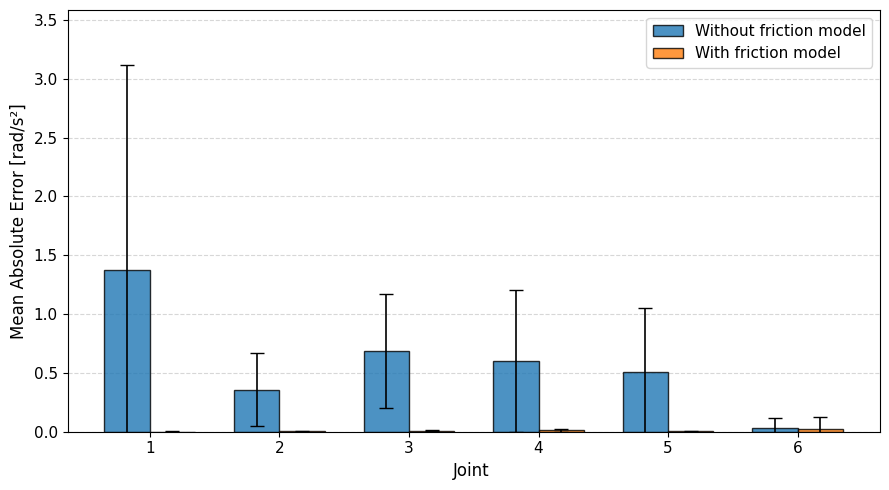

In [21]:

nq = 6
# Model WITHOUT friction
errors_nf = np.abs(computed_ddq_no_friction - real_ddq_no_friction)
mean_nf = np.mean(errors_nf, axis=0)
std_nf = np.std(errors_nf, axis=0)

# Model WITH friction
errors_f = np.abs(computed_ddq_friction - real_ddq_friction)
mean_f = np.mean(errors_f, axis=0)
std_f = np.std(errors_f, axis=0)
fig, ax = plt.subplots(figsize=(9, 5))

joint_indices = np.arange(1, nq + 1)
bar_width = 0.35

ax.bar(
    joint_indices - bar_width / 2,
    mean_nf,
    bar_width,
    yerr=std_nf,
    capsize=5,
    label="Without friction model",
    color="tab:blue",
    alpha=0.8,
    edgecolor="black",
    error_kw=dict(ecolor="black", lw=1.2),
)

ax.bar(
    joint_indices + bar_width / 2,
    mean_f,
    bar_width,
    yerr=std_f,
    capsize=5,
    label="With friction model",
    color="tab:orange",
    alpha=0.8,
    edgecolor="black",
    error_kw=dict(ecolor="black", lw=1.2),
)

ax.set_xlabel("Joint ", fontsize=12)
ax.set_ylabel("Mean Absolute Error [rad/s²]", fontsize=12)

ax.set_xticks(joint_indices)
ax.tick_params(axis="both", labelsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

ymax = max((mean_nf + std_nf).max(), (mean_f + std_f).max())
ax.set_ylim(0, ymax * 1.15)

ax.legend(fontsize=11)

plt.tight_layout()
plt.show()
